## **Implementasi Arsitektur Xception pada Deep Learning CNN untuk Klasifikasi Citra Kanker Kulit**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from keras.utils import plot_model

In [ ]:
# Fungsi untuk Load Data dengan Label yang Konsisten
def load_data(data_directory):
    images = []
    labels = []

    # Ambil daftar kelas dan urutkan agar sesuai dengan LabelEncoder
    class_names = sorted(os.listdir(data_directory))

    # Buat LabelEncoder dengan urutan kelas yang benar
    label_encoder = LabelEncoder()
    label_encoder.fit(class_names)

    for class_name in class_names:
        class_path = os.path.join(data_directory, class_name)

        if not os.path.isdir(class_path):
            continue  # Skip jika bukan direktori kelas

        for filename in os.listdir(class_path):
            filepath = os.path.join(class_path, filename)
            img = cv2.imread(filepath)

            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (224, 224))
                img = img / 255.0
                images.append(img)
                labels.append(class_name)  # Simpan sebagai string

    # Konversi label ke bentuk numerik dengan label_encoder
    labels = label_encoder.transform(labels)

    return np.array(images), np.array(labels), label_encoder

In [ ]:
# Load Dataset
data_directory = '/content/drive/MyDrive/kanker_kulit-2245'
images, labels, label_encoder = load_data(data_directory)

In [ ]:
# Split Data (Train, Validation, Test) dengan stratifikasi
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [ ]:
# Konversi label ke one-hot encoding
y_train = to_categorical(y_train, num_classes=len(label_encoder.classes_))
y_valid = to_categorical(y_valid, num_classes=len(label_encoder.classes_))
y_test = to_categorical(y_test, num_classes=len(label_encoder.classes_))

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

# Generator Data
train_generator = train_datagen.flow(X_train, y_train, batch_size=16)
val_generator = val_datagen.flow(X_valid, y_valid, batch_size=16)

In [ ]:
# Load model Xception tanpa fully connected layers (top=False)
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Buka beberapa layer terakhir agar bisa di-train
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Bangun model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer='l2'),  # Tambahkan Regularization
    Dropout(0.4),  # Dropout lebih besar
    Dense(len(label_encoder.classes_), activation='softmax')
])
# Menampilkan arsitektur model
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         5,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,916,211 (83.60 MB)

 Trainable params: 21,861,683 (83.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 116s 510ms/step - accuracy: 0.2580 - loss: 9.9591 - val_accuracy: 0.5357 - val_loss: 8.1192
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 32s 284ms/step - accuracy: 0.6051 - loss: 7.6989 - val_accuracy: 0.6250 - val_loss: 6.8478
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 298ms/step - accuracy: 0.7154 - loss: 6.3561 - val_accuracy: 0.6875 - val_loss: 5.6860
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 294ms/step - accuracy: 0.7945 - loss: 5.2929 - val_accuracy: 0.7232 - val_loss: 4.9704
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 33s 293ms/step - accuracy: 0.8392 - loss: 4.4329 - val_accuracy: 0.7143 - val_loss: 4.2820
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 291ms/step - accuracy: 0.8646 - loss: 3.7213 - val_accuracy: 0.6652 - val_loss: 3.9623
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 297ms/step - accuracy: 0.8808 - loss: 3.1516 - val_accuracy: 0.7277 - val_loss: 3.3829
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 33s 295ms/step - accuracy: 0.8988 - loss: 

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

best_epoch = val_accuracy.index(max(val_accuracy)) + 1  # Add 1 because epochs are 1-indexed

print(f"Best Accuracy: {accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")
print(f"Best Validation Accuracy: {val_accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")

Best Accuracy: 0.9477 at Epoch 44
Best Validation Accuracy: 0.7723 at Epoch 44


In [ ]:
y_hat_with_cnn = model.predict(X_test)
test_with_cnn = model.evaluate(X_test, y_test)
print('Test Loss = ', test_with_cnn[0], 'Test Accuracy = ', test_with_cnn[1])

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 683ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 415ms/step - accuracy: 0.7319 - loss: 1.1809
Test Loss =  1.1795575618743896 Test Accuracy =  0.7377777695655823


In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


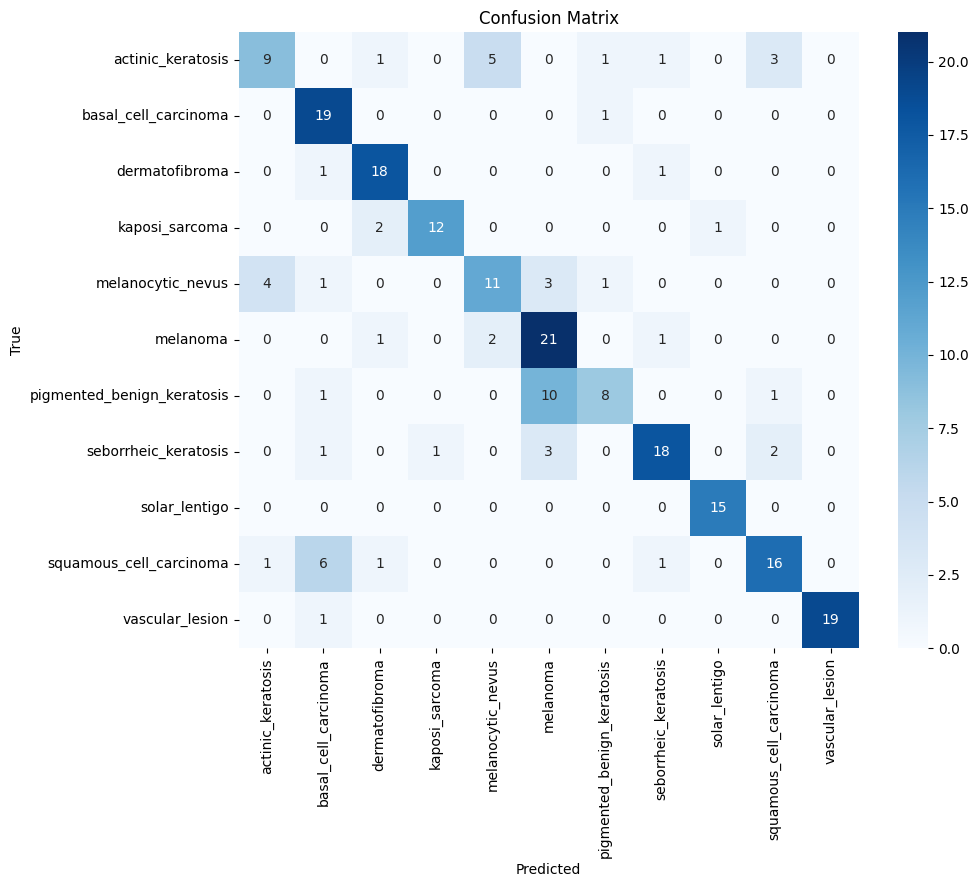

Classification Report:
                            precision    recall  f1-score   support

         actinic_keratosis       0.64      0.45      0.53        20
      basal_cell_carcinoma       0.63      0.95      0.76        20
            dermatofibroma       0.78      0.90      0.84        20
            kaposi_sarcoma       0.92      0.80      0.86        15
         melanocytic_nevus       0.61      0.55      0.58        20
                  melanoma       0.57      0.84      0.68        25
pigmented_benign_keratosis       0.73      0.40      0.52        20
      seborrheic_keratosis       0.82      0.72      0.77        25
             solar_lentigo       0.94      1.00      0.97        15
   squamous_cell_carcinoma       0.73      0.64      0.68        25
           vascular_lesion       1.00      0.95      0.97        20

                  accuracy                           0.74       225
                 macro avg       0.76      0.75      0.74       225
              weighted 

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print('Classification Report:')
print(classification_report(y_true, y_pred_classes,
                            target_names=label_encoder.classes_))

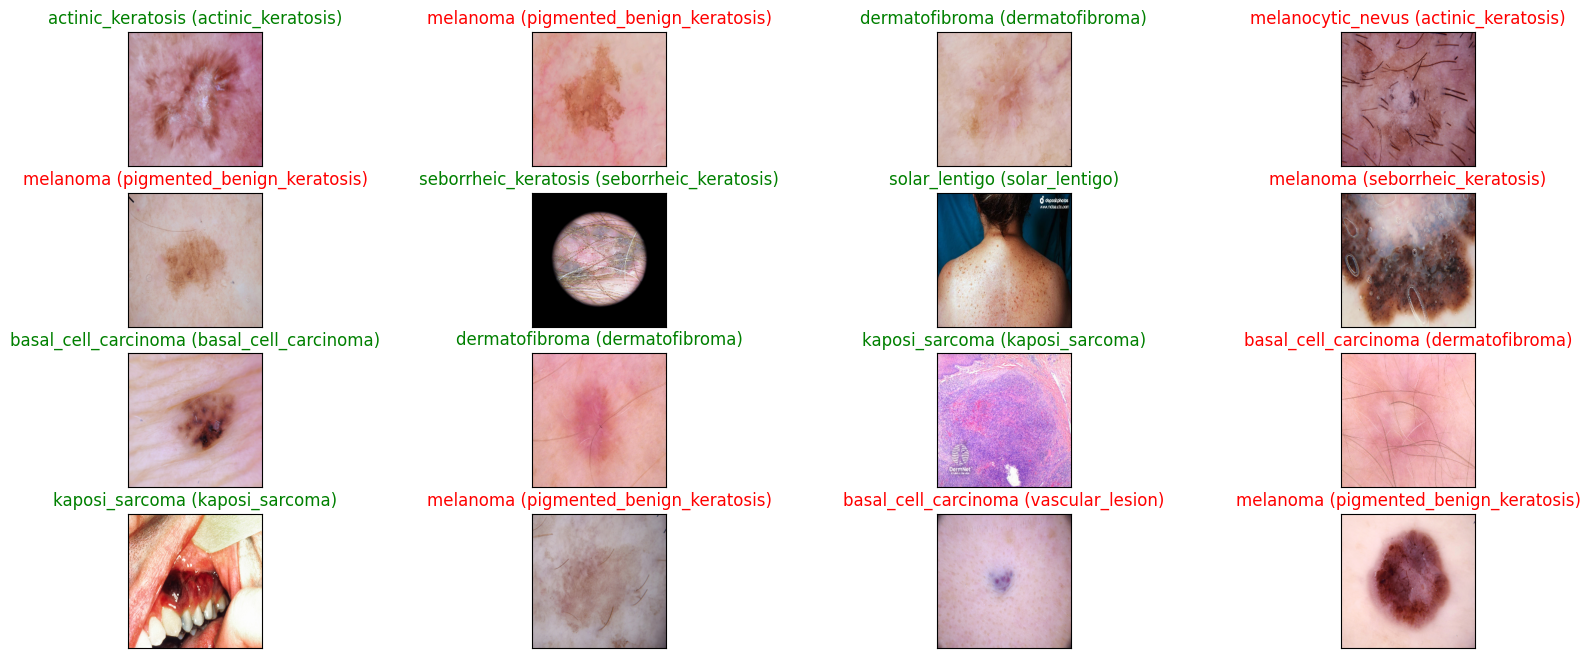

In [ ]:
classes = label_encoder.classes_
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(classes[pred_idx], classes[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

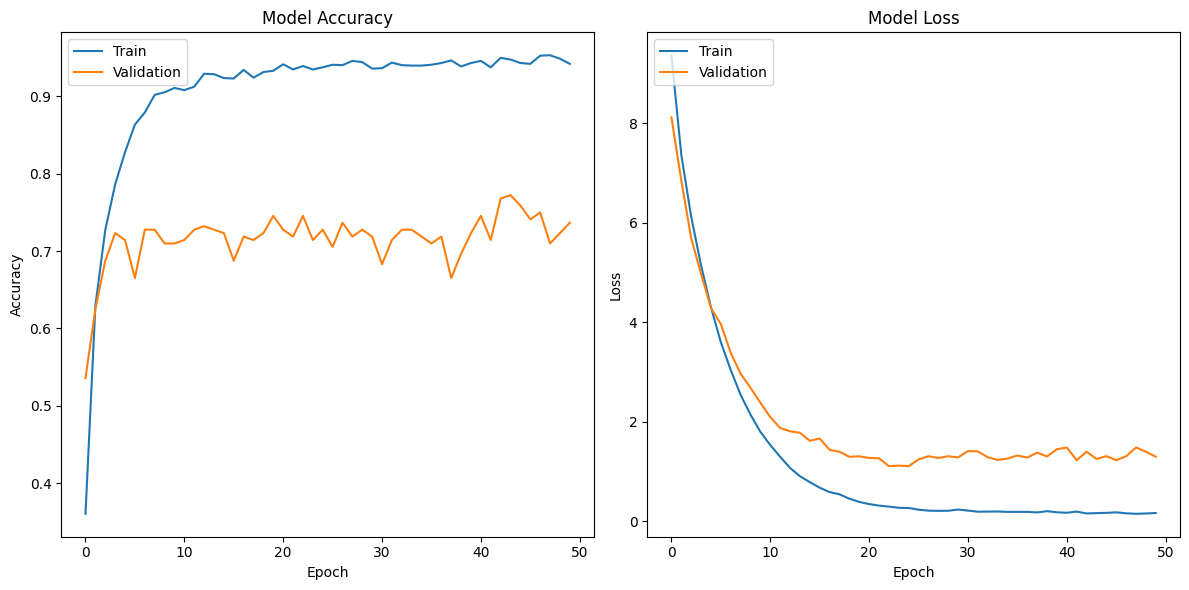

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
model.save('00015016.h5')